In [22]:
!pip install keras

In [38]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, SpatialDropout2D,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [39]:
def conv_block(x, n_base, batch_normalization):
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=n_base, kernel_size=(3,3), 
                        strides=(1,1),padding='same')(x)
    if (batch_normalization):
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [40]:
def downsample_block(x, n_base, batch_normalization, dropout):
    f = conv_block(x, n_base, batch_normalization)
    p = layers.MaxPool2D(pool_size = (2,2))(f)
    if(dropout):
        p = layers.Dropout(0.2)(p)
        
    return f, p

In [41]:
def upsample_block(x, f, n_base, batch_normalization, dropout):
    
    x = Conv2DTranspose(filters=n_base, kernel_size=(2,2), 
                         strides=(2,2),padding='same')(x)
    x = Concatenate()([x,f])
    if(dropout):
        x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_base, batch_normalization)
        
    return x

In [42]:
def get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout):

    
    
    ## Encoder part
#     model = Sequential()
    inputs = layers.Input((img_w, img_h, img_ch))
    
    f1, p1 = downsample_block(inputs, n_base, batch_normalization, dropout)
    f2, p2 = downsample_block(p1, n_base*2, batch_normalization, dropout)
    f3, p3 = downsample_block(p2, n_base*4, batch_normalization, dropout)
    f4, p4 = downsample_block(p3, n_base*8, batch_normalization, dropout)
    
    
    ## Bottleneck
    bottleneck = conv_block(p4, n_base*16, batch_normalization)
    
    ## Decoder part
    p5 = upsample_block(bottleneck, f4, n_base*8, batch_normalization, dropout)
    p6 = upsample_block(p5, f3, n_base*4, batch_normalization, dropout)
    p7 = upsample_block(p6, f2, n_base*2, batch_normalization, dropout)
    p8 = upsample_block(p7, f1, n_base, batch_normalization, dropout)

    
    ## 1 Convo layer
    p9 = Conv2D(filters=1, kernel_size=(1,1), 
                            padding='same')(p8)
    outputs = Activation('sigmoid')(p9)
    

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    
    return model


In [43]:
!pip install scikit-image

In [23]:
## Task1a) Lung segmentation in chest X-ray images:
import os
from random import shuffle
from skimage.io import imread
from skimage.transform import resize


image_path = '/DL_course_data/Lab3/MRI/Image' 
mask_path = '/DL_course_data/Lab3/MRI/Mask'



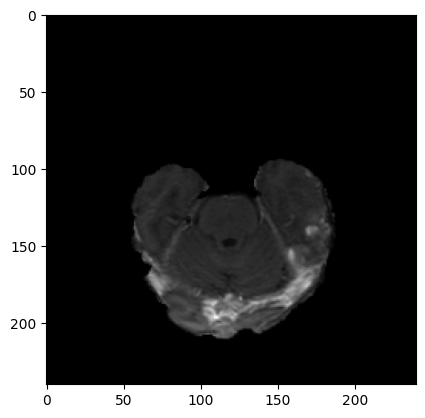

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568627,
       0.02352941, 0.02745098, 0.03137255, 0.03529412, 0.03921569,
       0.04313725, 0.04705882, 0.05098039, 0.05490196, 0.05882353,
       0.06666667, 0.07058824, 0.0745098 , 0.07843137, 0.08235294,
       0.08627451, 0.09019608, 0.09411765, 0.09803922, 0.10196078,
       0.10980392, 0.11372549, 0.11764706, 0.12156863, 0.1254902 ,
       0.12941176, 0.13333333, 0.1372549 , 0.14117647, 0.14901961,
       0.15294118, 0.15686275, 0.16078431, 0.16470588, 0.16862745,
       0.17254902, 0.17647059, 0.18039216, 0.18431373, 0.19215686,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568627, 0.21960784, 0.22352941, 0.23137255, 0.23529412,
       0.23921569, 0.24313725, 0.24705882, 0.25098039, 0.25490196,
       0.25882353, 0.2627451 , 0.26666667, 0.2745098 , 0.27843137,
       0.28235294, 0.28627451, 0.29019608, 0.29411765, 0.29803922,
       0.30196078, 0.30588235, 0.30980392, 0.31764706, 0.32156

In [37]:
file = 'Brats17_2013_4_1_t1ce_46.png'
img = imread(os.path.join(image_path, file), as_gray=True)
plt.imshow(img, cmap='gray')
plt.show()

np.unique(img)

resize(img, (240, 240), anti_aliasing=False).astype('float32')
np.unique(img/255)

In [44]:
def load_data(image_path,mask_path):
    
    image_list = os.listdir(image_path)
    mask_list = os.listdir(mask_path)
    
    images = []
    masks = []

    for image in image_list:
        img = imread(os.path.join(image_path, image), as_gray=True)  # "as_grey"
        img = resize(img, (240, 240), anti_aliasing=True).astype('float32')
        images.append(img)

    for mask in mask_list:
        mask_img = imread(os.path.join(mask_path, mask), as_gray=True)
        mask_img = resize(mask_img, (240, 240), anti_aliasing=True).astype('float32')
        masks.append(mask_img)
        
    ## Load data in traditional way
    # img_train, img_val, mask_train, mask_val = train_test_split(images, masks, shuffle = True,
    #                                                   test_size = 0.2)

    images = np.expand_dims(images, axis = -1)
    images = np.array(images)

    masks = np.expand_dims(masks, axis = -1)
    masks = np.array(masks)
    
    return images, masks
    

In [45]:
from tensorflow.keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 0.0001) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.0001)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [46]:
n_base =8
LR = 1e-4
batch_normalization = True
dropout = True
epochs = 100
Metric= 'Dice Coefficient'
batch_size = 8

img_w, img_h = 240,240
img_ch = 1

In [47]:
images, masks = load_data(image_path,mask_path)

In [48]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
cvscores = []


In [51]:
def generator(x_train, y_train, batch_size):
    n_train_sample = len(x_train)
    while True:
        for ind in (range(0, n_train_sample, batch_size)):
            
            batch_img = x_train[ind:ind+batch_size]
            batch_label = y_train[ind:ind+batch_size]
            
            # Sanity check assures batch size always satisfied
            # by repeating the last 2-3 images at last batch.
            length = len(batch_img)
            if length == batch_size:
                pass
            else:
                for tmp in range(batch_size - length):
                    batch_img = np.append(batch_img, np.expand_dims(batch_img[-1],axis=0), axis = 0)
                    batch_label = np.append(batch_label, np.expand_dims(batch_label[-1], axis=0), axis = 0)
        
            backgound_value = x_train.min()
            data_gen_args = dict(rotation_range=10.,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     cval = backgound_value,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen = ImageDataGenerator(**data_gen_args)
            
            image_generator = image_datagen.flow(batch_img, shuffle=False,
                                                 batch_size=batch_size,
                                                 seed=1)
            
            mask_generator = mask_datagen.flow(batch_label, shuffle=False,
                                               batch_size=batch_size,
                                               seed=1)
            
            image = image_generator.next()
            label = mask_generator.next()
            
            yield image, label

In [52]:
from matplotlib import image

for train, val in kf.split(images):
    image_train, image_val = images[train],images[val]
    mask_train, mask_val = masks[train], masks[val]
    ## Get model
    model = get_unet(img_w, img_h, img_ch, n_base, LR, batch_normalization, dropout)
    train_generator = generator(image_train, mask_train, batch_size)
    val_generator = generator(image_val, mask_val, batch_size)

#     ## Add augmentation
#     image_aug = ImageDataGenerator(rotation_range=10,
#                                     width_shift_range=0.1,
#                                     height_shift_range=0.1,
#                                     zoom_range = 0.2,
#                                     horizontal_flip=True)

#     train_generator = image_aug.flow(
#                                     image_train,mask_train,
#                                     batch_size = batch_size)

#     val_generator = image_aug.flow(
#                                     image_val,mask_val,
#                                     batch_size = batch_size)


    # Compile the model
    model.compile(loss = [dice_coef_loss],          # Model Compiling   
                optimizer = Adam(lr = LR),
                metrics = [dice_coef, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    model_history = model.fit(train_generator, 
                validation_data = (val_generator), batch_size = batch_size,
                epochs = epochs,  verbose=1)


    # evaluate the model
    scores = model.evaluate(image_val, mask_val, verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

    plt.figure(figsize=(4, 4))
    plt.title("Learning curve")
    plt.plot(model_history.history["loss"], label="loss")
    plt.plot(model_history.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(model_history.history["val_loss"]),
            np.min(model_history.history["val_loss"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.legend()
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.title("Dice Coefficients")
    plt.plot(model_history.history['dice_coef'], label="dice")
    plt.plot(model_history.history['val_dice_coef'], label="val_dice")
    plt.plot( np.argmax(model_history.history["val_dice_coef"]),
            np.max(model_history.history["val_dice_coef"]),
            marker="x", color="r", label="best model")

    plt.xlabel("Epochs")
    plt.ylabel("Dice Coef")
    plt.legend()
    plt.show()

    
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 240, 240, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 240, 240, 8)  80          ['input_3[0][0]']                
                                                                                                  
 batch_normalization_36 (BatchN  (None, 240, 240, 8)  32         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                            

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


    973/Unknown - 135s 137ms/step - loss: 0.9998 - dice_coef: 2.1904e-04 - precision_2: 0.0545 - recall_2: 0.8865

KeyboardInterrupt: 

In [73]:
cvscores

[2.9252661392092705, 10.042130947113037, 4.18890155851841, 3.611527383327484]

In [74]:
model.metrics_names

['loss', 'dice_coef', 'precision_8', 'recall_8']